In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [5]:
#file is 1984-85 to last year, file2 is 2019-20 only
file = pd.ExcelFile("COMBINED_NORMAL_ADVANCED_STATS_1984-85_to_2019-20_ver2.xlsx")
data = pd.read_excel(file, 0)
file2 = pd.ExcelFile("2019_20_FINAL_normal_advanced_stats_V2.xlsx")
data_2020 = pd.read_excel(file2, 0)
data.columns

Index(['slug', 'name', 'positions', 'age', 'team', 'games_played',
       'games_started', 'minutes_played', 'made_field_goals',
       'attempted_field_goals', 'made_three_point_field_goals',
       'attempted_three_point_field_goals', 'made_free_throws',
       'attempted_free_throws', 'offensive_rebounds', 'defensive_rebounds',
       'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls', 'points',
       'player_efficiency_rating', 'true_shooting_percentage',
       'three_point_attempt_rate', 'free_throw_attempt_rate',
       'offensive_rebound_percentage', 'defensive_rebound_percentage',
       'total_rebound_percentage', 'assist_percentage', 'steal_percentage',
       'block_percentage', 'turnover_percentage', 'usage_percentage',
       'offensive_win_shares', 'defensive_win_shares', 'win_shares',
       'win_shares_per_48_minutes', 'offensive_box_plus_minus',
       'defensive_box_plus_minus', 'box_plus_minus',
       'value_over_replacement_player', 'Year', 'key'],
    

In [6]:
data = data.drop(columns=['slug', 'key'])
data_2020 = data_2020.drop(columns=['Unnamed: 0'])

In [7]:
columns_match = all([data.columns.values[i]==data_2020.columns.values[i] for i in range(len(data.columns.values))])

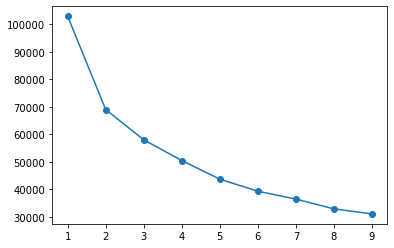

In [8]:
# test_data: 2019-2020 data saved as data_2020
# the purpose of this cell is to make a line plot of the sum of the squares of the distances for the "elbow test"
data_3D = data[["made_three_point_field_goals", "attempted_three_point_field_goals", "three_point_attempt_rate", "steal_percentage","defensive_win_shares", "defensive_box_plus_minus"]]

#the data is standardized because not every feature is based on the same scale
data_std = StandardScaler().fit_transform(data_3D)
wcss = []
for i in range(1, 10):
    kmeans_3D = KMeans(n_clusters=i).fit(data_std)
    wcss.append(kmeans_3D.inertia_)
plt.plot(range(1, 10), wcss, marker='o')

In [9]:
#based on the chosen num_clusters, sets the kmeans_3D variable
num_clusters = 3
kmeans_3D = KMeans(n_clusters=num_clusters).fit(data_std)

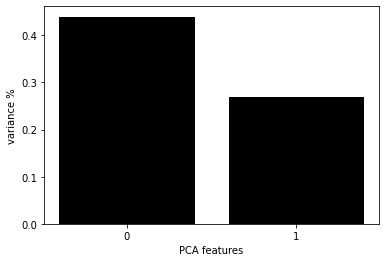

In [10]:
#Use PCA to visualize the clusters in two-dimensions
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_std)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

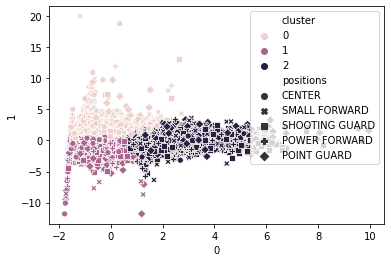

In [11]:
PCA_components['cluster'] = kmeans_3D.labels_
PCA_components['positions'] = data['positions']
sns.scatterplot(data=PCA_components, x=0, y=1, hue="cluster", style="positions")

In [12]:
#repeats the same process as above; this time with a preliminary filter applied (maybe to reduce noise?)
data_filter = data.loc[data['minutes_played'] >= 20]
data_filter = data_filter.loc[data_filter["three_point_attempt_rate"] > 0.3]
data_filter = data_filter.loc[data_filter["defensive_box_plus_minus"] > 0]
print(data.shape, data_filter.shape)

(17161, 42) (950, 42)


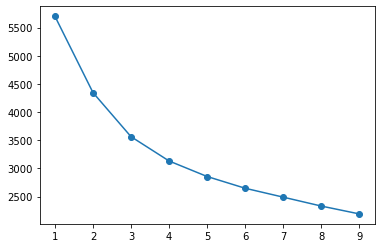

In [13]:
# test_data: 2019-2020 data saved as data_2020
data_3D_filter = data_filter[["made_three_point_field_goals", "attempted_three_point_field_goals", "three_point_attempt_rate", "steal_percentage","defensive_win_shares", "defensive_box_plus_minus"]]
data_std_filter = StandardScaler().fit_transform(data_3D_filter)
wcss_filter = []
for i in range(1, 10):
    kmeans_3D_filter = KMeans(n_clusters=i).fit(data_std_filter)
    wcss_filter.append(kmeans_3D_filter.inertia_)
plt.plot(range(1, 10), wcss_filter, marker='o')

In [14]:
num_clusters = 3
kmeans_3D_filter = KMeans(n_clusters=num_clusters).fit(data_std_filter)

,0,1,cluster,positions
0,-2.157261,-1.038398,0,POINT GUARD
1,-1.287475,-0.175199,0,SHOOTING GUARD
2,0.762953,1.032136,2,POINT GUARD
3,-2.180957,-0.623283,0,POWER FORWARD
4,-1.397679,-0.113304,0,SHOOTING GUARD


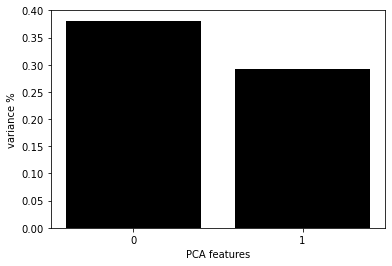

In [15]:
#Use PCA to visualize the clusters
pca_filter = PCA(n_components=2)
principalComponents_filter = pca_filter.fit_transform(data_std_filter)
features_filter = range(pca_filter.n_components_)
plt.bar(features_filter, pca_filter.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features_filter)

PCA_components_filter = pd.DataFrame(principalComponents_filter)
PCA_components_filter['cluster'] = kmeans_3D_filter.labels_
PCA_components_filter['positions'] = data_filter['positions'].reset_index()['positions']
PCA_components_filter.head(5)

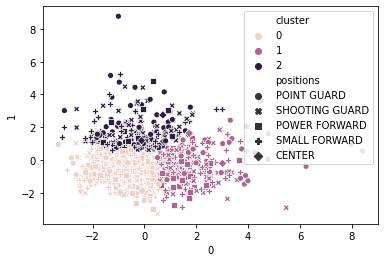

In [16]:
sns.scatterplot(data=PCA_components_filter, x=0, y=1, hue="cluster", style="positions")

In [17]:
results = data_3D_filter.reset_index()
results['name'] = data_filter.reset_index()['name']
results['cluster'] = PCA_components_filter.reset_index()['cluster']

results.groupby('cluster').agg('mean')

,index,made_three_point_field_goals,attempted_three_point_field_goals,three_point_attempt_rate,steal_percentage,defensive_win_shares,defensive_box_plus_minus
cluster,,,,,,,
0,11528.344330,1.195145,3.248208,0.422940,1.805773,1.750928,0.580412
1,12027.124031,2.172771,5.701970,0.513671,1.996512,2.788760,0.787984
2,10659.429952,1.249122,3.482161,0.396928,2.674396,3.049758,1.817391


In [18]:
results.to_excel("filtered_THREE_DEFENSE_results.xlsx")

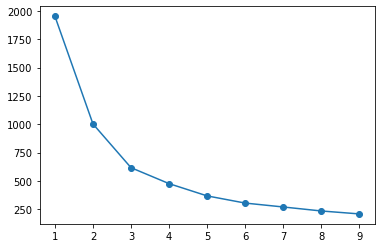

In [26]:
#KMEANS without the filter to identify 3andD players and/or 3pt specialists -- first try
data_2020_3D = data_2020[["made_three_point_field_goals", "attempted_three_point_field_goals", "three_point_attempt_rate"]]
data_2020_3D = data_2020_3D.fillna(0)
std_2020 = StandardScaler().fit_transform(data_2020_3D)
wcss_filter = []
for i in range(1, 10):
    kmeans_3D_filter = KMeans(n_clusters=i).fit(std_2020)
    wcss_filter.append(kmeans_3D_filter.inertia_)
plt.plot(range(1, 10), wcss_filter, marker='o')
kmeans_2020 = KMeans(n_clusters=3).fit(std_2020)



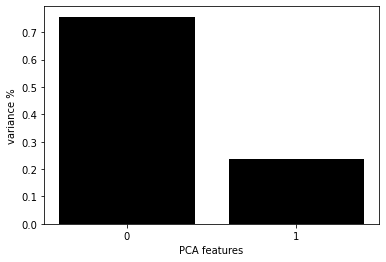

In [27]:
pca_2020 = PCA(n_components=2)
principalComponents = pca_2020.fit_transform(std_2020)
features = range(pca_2020.n_components_)
plt.bar(features, pca_2020.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)
PCA_components['cluster'] = kmeans_2020.labels_
PCA_components['positions'] = data_2020.reset_index()['positions']


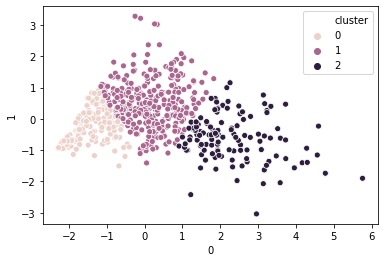

In [28]:
sns.scatterplot(data=PCA_components, x=0, y=1, hue="cluster")

In [24]:
data_2020_3D['cluster'] = PCA_components['cluster']
data_2020_3D['name'] = data_2020.reset_index()['name']
data_2020_3D.groupby('cluster').agg('median')

,made_three_point_field_goals,attempted_three_point_field_goals,three_point_attempt_rate
cluster,,,
0,2.45,6.5,0.4735
1,0.50,1.6,0.4265
2,1.30,3.6,0.4900
3,0.00,0.2,0.0510


In [23]:
data_2020_3D.to_excel("clustered_2020_3pt_specialists.xlsx")